In [4]:
import os
import sys
from joblib import dump, load

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning
from nlp import tokenize_doc

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False
)

In [5]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
    & (jobs["Profile"] != "")
]
texts = jobs["Titel"] + " " + jobs["Description"] + " " + jobs["Profile"]

# Preprocessing

In [6]:
# Tokenize all job postings
import pickle

if os.path.isfile("../data/lemmatized.pkl"):
    with open("../data/lemmatized.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas
        
    with open("../data/lemmatized.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 15782 documents
500/15782
1000/15782
1500/15782
2000/15782
2500/15782
3000/15782
3500/15782
4000/15782
4500/15782
5000/15782
5500/15782
6000/15782
6500/15782
7000/15782
7500/15782
8000/15782
8500/15782
9000/15782
9500/15782
10000/15782
10500/15782
11000/15782
11500/15782
12000/15782
12500/15782
13000/15782
13500/15782
14000/15782
14500/15782
15000/15782
15500/15782


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('data', 19408),
 ('team', 15571),
 ('bereich', 13745),
 ('erfahrung', 11553),
 ('kenntnis', 9778),
 ('management', 9739),
 ('business', 9368),
 ('studium', 9148),
 ('abgeschlossen', 9024),
 ('junior', 8009)]

In [24]:
# Vectorize and lsa
from time import time

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Feature Extraction using TfidfVectorizer


def custom_tokenizer(x):
    return x


def custom_preprocessor(x):
    return x


vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    preprocessor=custom_preprocessor,
    min_df=10,
    max_df=0.5,
)

t0 = time()
X_tfidf = vectorizer.fit_transform(lemmas)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

print(f"Sparsity: {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

# Performing dimensionality reduction using LSA
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vectorization done in 0.655 s
n_samples: 15782, n_features: 10674
Sparsity: 0.008
LSA done in 2.259 s
Explained variance of the SVD step: 19.8%


# Clustering with kmeans

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def cluster_means(n, X_lsa):
    t0 = time()

    inertias = {}
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, max_iter=100, n_init=1, random_state=1)

        kmeans.fit(X_lsa)
        inertias[k] = kmeans.inertia_

    print(f"Clustering done in {time() - t0:.3f} s")

    plt.figure()
    plt.plot(inertias.keys(), inertias.values())
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()


def terms_per_cluster(lsa, vectorizer, kmeans, n):
    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(n):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :20]:
            print(f"{terms[ind]} ", end="")
        print()

Clustering done in 5.576 s


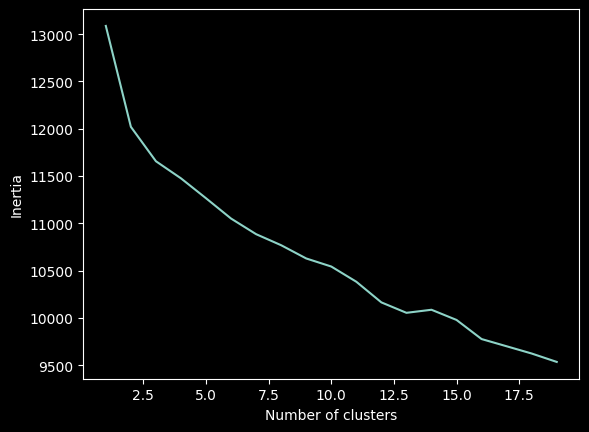

In [26]:
cluster_means(20, X_lsa)

# Top terms per Cluster

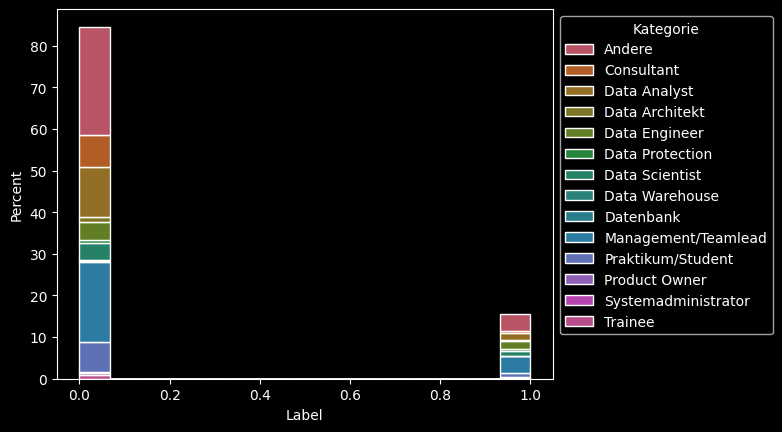

In [27]:
import seaborn as sns

cluster_count = 2
kmeans = KMeans(n_clusters=cluster_count, max_iter=100, n_init=1, random_state=2)


kmeans.fit(X_lsa)


labels = kmeans.labels_

df_eval = pd.DataFrame({"Label": labels, "Kategorie": jobs.loc[:, "Job Kategorie"]})

# display(df_eval.groupby("Kategorie").value_counts(subset=["Label"], normalize=True))
by_label = df_eval.groupby("Label").value_counts(subset=["Kategorie"], normalize=True)

ax = sns.histplot(
    data=df_eval, x="Label", hue="Kategorie", multiple="stack", stat="percent"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# terms_per_cluster(lsa, vectorizer, kmeans, cluster_count)

# Salary Prediction

In [28]:
jobs_with_salary = jobs[(jobs["Gehalt_max_yearly"].notna()) & (jobs["Job Kategorie"] == "Data Scientist") | (jobs["Job Kategorie"] == "Data Analyst") ]

## Outlier Detection

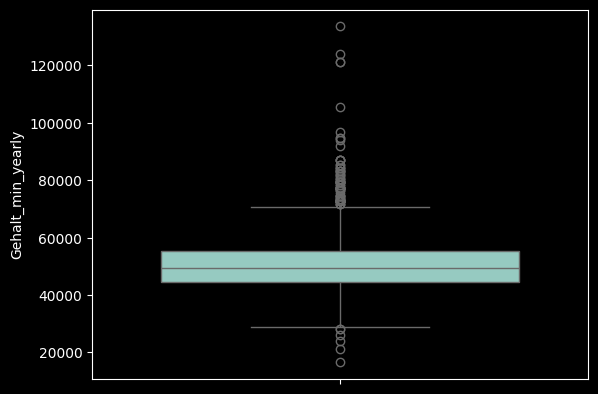

In [29]:
# Outlier detection
import seaborn as sns

g = sns.boxplot(
    data=jobs_with_salary,
    y="Gehalt_min_yearly",
    gap=0.1,
    legend=True,
)

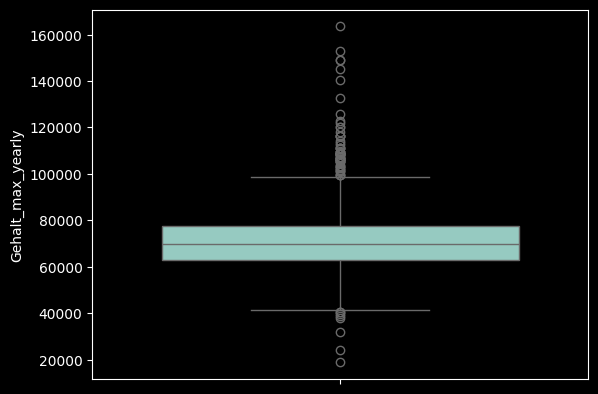

In [30]:
h = sns.boxplot(
    data=jobs_with_salary,
    y="Gehalt_max_yearly",
    gap=0.1,
    legend=True,
)

In [31]:
# anzahl outliers
outlier_cond = (
    (jobs_with_salary["Gehalt_min_yearly"] <= 20_000)
    | (jobs_with_salary["Gehalt_min_yearly"] >= 80_000)
    | (jobs_with_salary["Gehalt_max_yearly"] >= 120_000)
)
outliers = jobs_with_salary[outlier_cond]
# outliers

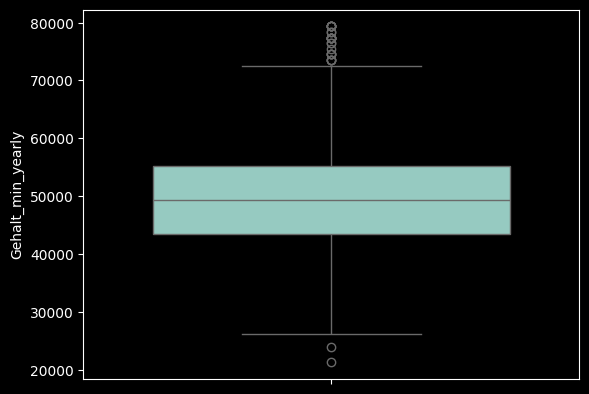

In [32]:
no_outliers = jobs_with_salary[~outlier_cond].reset_index()

h = sns.boxplot(
    data=no_outliers,
    y="Gehalt_min_yearly",
    gap=0.1,
)

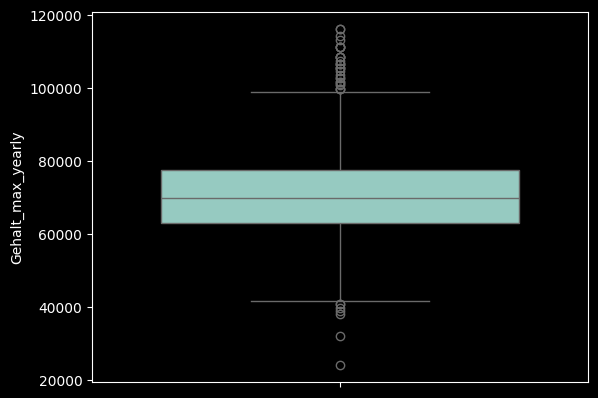

In [33]:
h = sns.boxplot(
    data=no_outliers,
    y="Gehalt_max_yearly",
    gap=0.1,
)

In [34]:
indeces = list(no_outliers.index)

X_lsa_no_outliers = [X_lsa[i] for i in indeces]

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


def model_eval(lsa, df, name=None):
    if name is not None:
        print(f"\n**{name}**")
    
    indeces = list(df.index)

    X = [lsa[i] for i in indeces]

    columns = ["Gehalt_min_yearly", "Gehalt_max_yearly"]
    for column in columns:
        y = df[column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=0
        )

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        param_grid = {"alpha": np.arange(0.0001, 1, 10), "solver": ["lsqr", "sag"]}
        ridge = Ridge(max_iter=15_000)
        ridge_cv = GridSearchCV(ridge, param_grid, cv=kf)
        ridge_cv.fit(X_train, y_train)

        best_params = ridge_cv.best_params_
        ridge = Ridge(**best_params)
        ridge.fit(X_train, y_train)

        y_pred = ridge.predict(X_test)
        rse = np.sqrt(mean_squared_error(y_pred, y_test, squared=True))
        score = ridge.score(X_test, y_test)

        print(
            f"\n{column}: \n  - Parameter: {best_params}\n  - RSE: {np.round(rse, 3)}\n  - Score: {np.round(score, 3)}"
        )

## Modelling

In [36]:
# Ein Modell
model_eval(X_lsa_no_outliers, no_outliers)


Gehalt_min_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'lsqr'}
  - RSE: 8542.509
  - Score: -0.029

Gehalt_max_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'lsqr'}
  - RSE: 11767.642
  - Score: -0.051


In [37]:
# Zwei Modelle
categories = ["Data Scientist", "Data Analyst"]
for category in categories:
	model_eval(X_lsa_no_outliers, no_outliers[no_outliers["Job Kategorie"] == category], category)


**Data Scientist**

Gehalt_min_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'lsqr'}
  - RSE: 11808.277
  - Score: -0.461

Gehalt_max_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'sag'}
  - RSE: 15530.362
  - Score: -0.407

**Data Analyst**

Gehalt_min_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'lsqr'}
  - RSE: 8171.713
  - Score: -0.117

Gehalt_max_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'sag'}
  - RSE: 10935.721
  - Score: -0.141


In [38]:
# Cluster Modelle
no_outliers["cluster"] = kmeans.predict(X_lsa_no_outliers)
cluster_count = no_outliers["cluster"].nunique()

for cluster in range(cluster_count):
	model_eval(X_lsa, no_outliers[no_outliers["cluster"] == cluster], f"Cluster {cluster}")


**Cluster 0**

Gehalt_min_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'lsqr'}
  - RSE: 9170.427
  - Score: -0.052

Gehalt_max_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'lsqr'}
  - RSE: 11898.504
  - Score: -0.054

**Cluster 1**


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Gehalt_min_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'sag'}
  - RSE: 13833.269
  - Score: -1.584

Gehalt_max_yearly: 
  - Parameter: {'alpha': 0.0001, 'solver': 'sag'}
  - RSE: 19605.107
  - Score: -1.43


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
